In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab 
import seaborn as sns
from scipy.stats import mode
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import requests
%matplotlib inline
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = (12, 8)
from wordcloud import WordCloud
import os


# Reading Raw Data

In [79]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [80]:
train.shape

(8523, 12)

CONCATINATING TRAIN AND TEST 

In [81]:
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print train.shape, test.shape, data.shape


(8523, 13) (5681, 12) (14204, 13)


# OBSERVATIONS

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
Item_Fat_Content             14204 non-null object
Item_Identifier              14204 non-null object
Item_MRP                     14204 non-null float64
Item_Outlet_Sales            8523 non-null float64
Item_Type                    14204 non-null object
Item_Visibility              14204 non-null float64
Item_Weight                  11765 non-null float64
Outlet_Establishment_Year    14204 non-null int64
Outlet_Identifier            14204 non-null object
Outlet_Location_Type         14204 non-null object
Outlet_Size                  10188 non-null object
Outlet_Type                  14204 non-null object
source                       14204 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 1.4+ MB


In [83]:
data.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

Note that the Item_Outlet_Sales is the target variable and missing values are ones in the test set. So we need not worry about it. But we’ll change the missing values in Item_Weight and Outlet_Size while cleaning the data.

In [84]:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [85]:
#data.apply(lambda x: len(x.unique()))

In [86]:
data.nunique()

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3493
Item_Type                       16
Item_Visibility              13006
Item_Weight                    415
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      3
Outlet_Type                      4
source                           2
dtype: int64

By this we can understand that there are 1559 products and 10 outlets as there 1559 unique Item_Identifier and 10 Outlet_identifier

Text(0.5,1,'Item_Outlet_Sales Distribution')

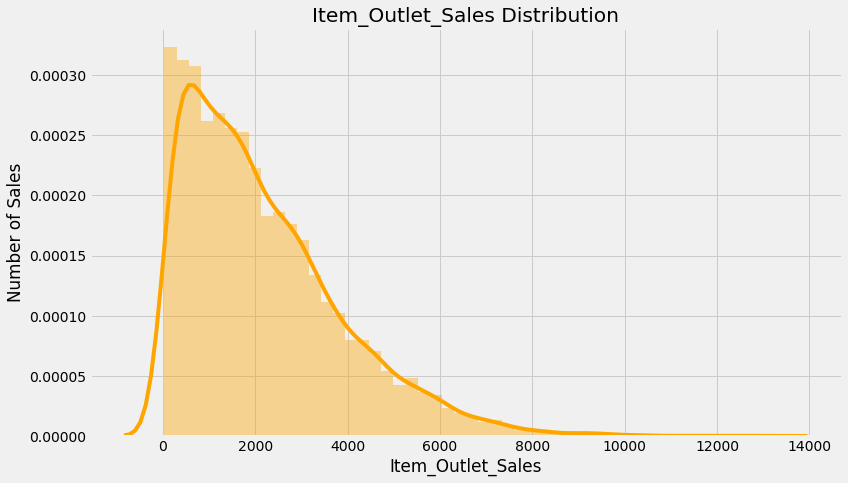

In [87]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,7))
sns.distplot(train.Item_Outlet_Sales, bins = 50,color='orange')
plt.ticklabel_format(style='plain', axis='x', scilimits=(0,1))
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Number of Sales")
plt.title("Item_Outlet_Sales Distribution")

In [88]:
#categories
columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
columns = [x for x in columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories
for column in columns:
    print '\nFrequency of Categories for varible %s'%column
    print data[column].value_counts()


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

## Visualizing all the Categories 

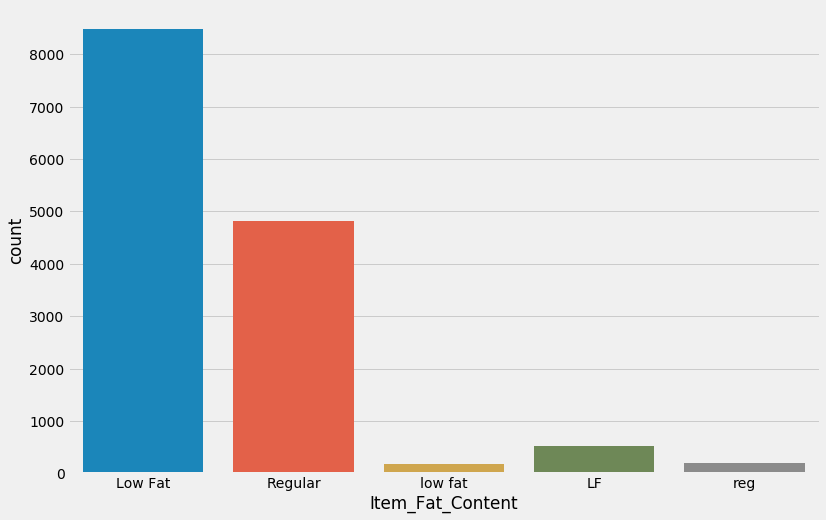

In [89]:
sns.countplot(data.Item_Fat_Content)

Some of ‘Low Fat’ values are given as ‘low fat’ and ‘LF’. Also, some of ‘Regular’ are mentioned as ‘regular’.

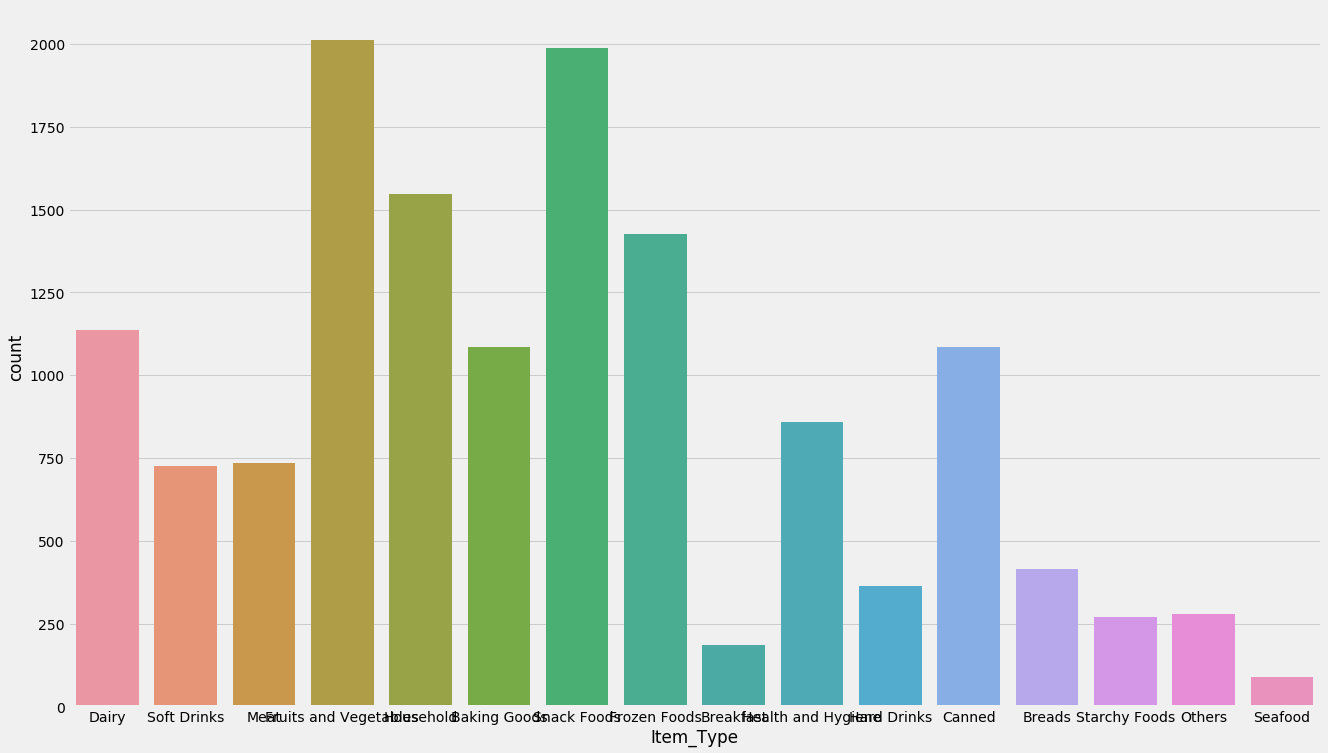

In [90]:
plt.figure(figsize=(20,12))
sns.countplot(data.Item_Type)

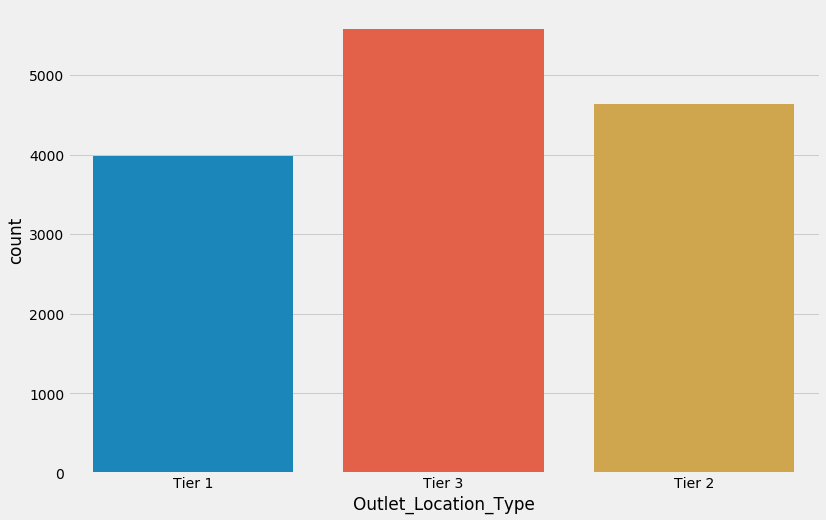

In [91]:
sns.countplot(data.Outlet_Location_Type)

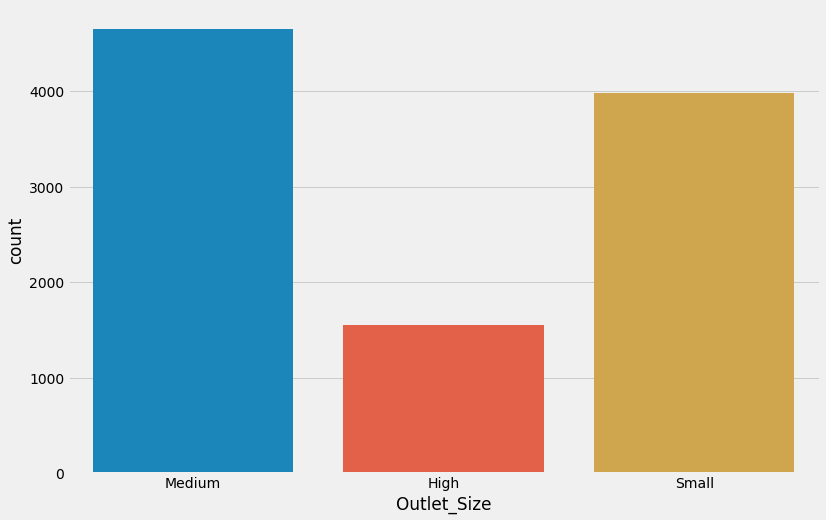

In [92]:
sns.countplot(data.Outlet_Size)

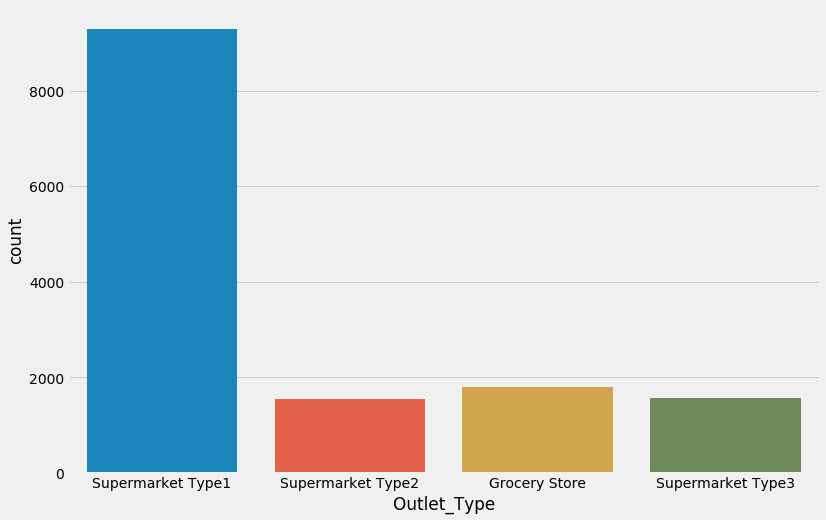

In [93]:

sns.countplot(data.Outlet_Type)

## CLEANING THE DATA

In [94]:
data.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

In [95]:
mean_value=data['Item_Weight'].mean()
data['Item_Weight']=data['Item_Weight'].fillna(mean_value)

In [96]:
data.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                     0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

In [97]:
from scipy.stats import mode
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )

mode_value = data['Outlet_Size'].isnull() 
data.loc[mode_value,'Outlet_Size'] = data.loc[mode_value,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

In [98]:
data.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                     0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                     0
Outlet_Type                     0
source                          0
dtype: int64

In [99]:
data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


# DATA PREPROCESSING

In [100]:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,14204.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.234226,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,9.300000,1987.000000
50%,142.247000,1794.331000,0.054021,12.792854,1999.000000
75%,185.855600,3101.296400,0.094037,16.000000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


Here in Item_Visibility the min value is 0 which in practical makes no sense. So by considering it has missing information replaced 0 by its mean value.

In [101]:
data.loc[data.Item_Visibility == 0.00,['Item_Visibility']] = np.nan

In [102]:
median_value=data['Item_Visibility'].median()
data['Item_Visibility'].fillna(median_value,inplace = True)

In [103]:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,14204.000000,14204.000000
mean,141.004977,2181.288914,0.069533,12.792854,1997.830681
std,62.086938,1706.499616,0.048683,4.234226,8.371664
min,31.290000,33.290000,0.003575,4.555000,1985.000000
25%,94.012000,834.247400,0.033143,9.300000,1987.000000
50%,142.247000,1794.331000,0.057851,12.792854,1999.000000
75%,185.855600,3101.296400,0.094037,16.000000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [104]:
data.Item_Visibility.isnull().sum()

0

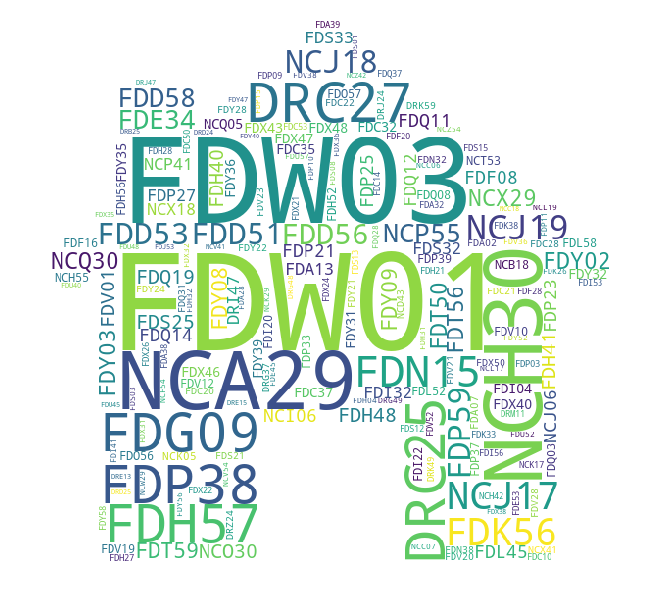

In [105]:
mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/O/i/x/Y/q/P/yellow-house-hi.png', stream=True).raw))
word_cloud = WordCloud(width = 500, height = 500, background_color='white', stopwords=STOPWORDS, mask=mask).generate(" ".join(data.Item_Identifier.astype(str)))
#word_cloud = WordCloud(width = 512, height = 512, background_color='white', stopwords=STOPWORDS, mask=mask).generate(words)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


Got first two characters of the Item_Identifier and renamed them to other category

In [106]:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [107]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Combined
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,Drinks
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.057851,19.20,1998,OUT010,Tier 3,Small,Grocery Store,train,Food
4,Low Fat,NCD19,53.8614,994.7052,Household,0.057851,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train,Non-Consumable


In [108]:
#Years:
data['Outlet_Years'] = 2018 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        20.169319
std          8.371664
min          9.000000
25%         14.000000
50%         19.000000
75%         31.000000
max         33.000000
Name: Outlet_Years, dtype: float64

In [109]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Combined,Outlet_Years
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,19
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,Drinks,9
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,19
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.057851,19.20,1998,OUT010,Tier 3,Small,Grocery Store,train,Food,20
4,Low Fat,NCD19,53.8614,994.7052,Household,0.057851,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train,Non-Consumable,31


In [110]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print data['Item_Fat_Content'].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [111]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Combined,Outlet_Years
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,19
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,Drinks,9
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,19
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.057851,19.20,1998,OUT010,Tier 3,Small,Grocery Store,train,Food,20
4,Low Fat,NCD19,53.8614,994.7052,Household,0.057851,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train,Non-Consumable,31


If you Observe the table it says Low Fat content for a Non-Consumable item which is not right. So, i created a seperate category saying Non-Edible for all Non-Consumable Items.

In [112]:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

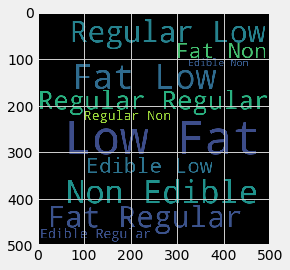

In [113]:
wordcloud = WordCloud(width = 500, height = 500).generate(" ".join(data.Item_Fat_Content.astype(str)))
plt.figure(figsize = (6, 4))
plt.imshow(wordcloud)
plt.show()

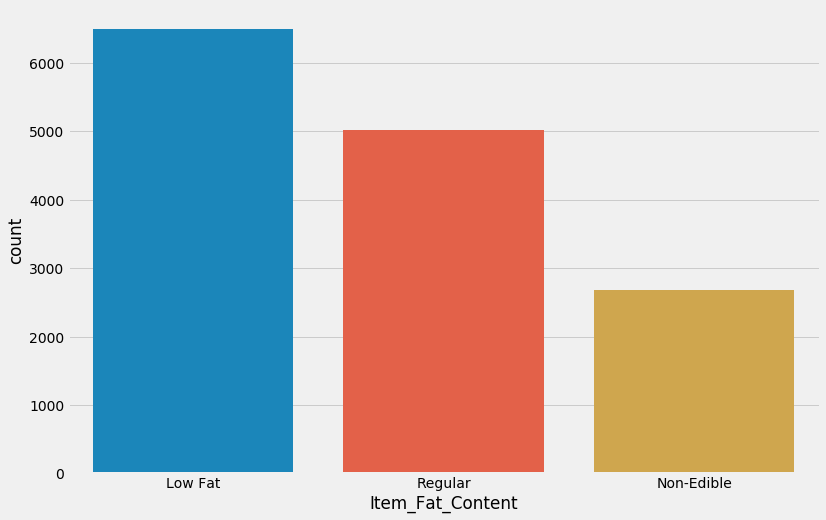

In [114]:
sns.countplot(data.Item_Fat_Content)

In [115]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Combined,Outlet_Years
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,19
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,Drinks,9
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,19
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.057851,19.20,1998,OUT010,Tier 3,Small,Grocery Store,train,Food,20
4,Non-Edible,NCD19,53.8614,994.7052,Household,0.057851,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train,Non-Consumable,31


## Now it is time to understand the relationship between our target variable and predictors as well as the relationship among predictors.

CORRELATION 

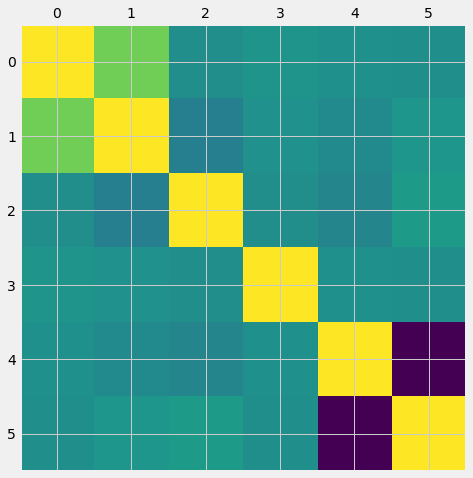

In [116]:
plt.matshow(data.corr())

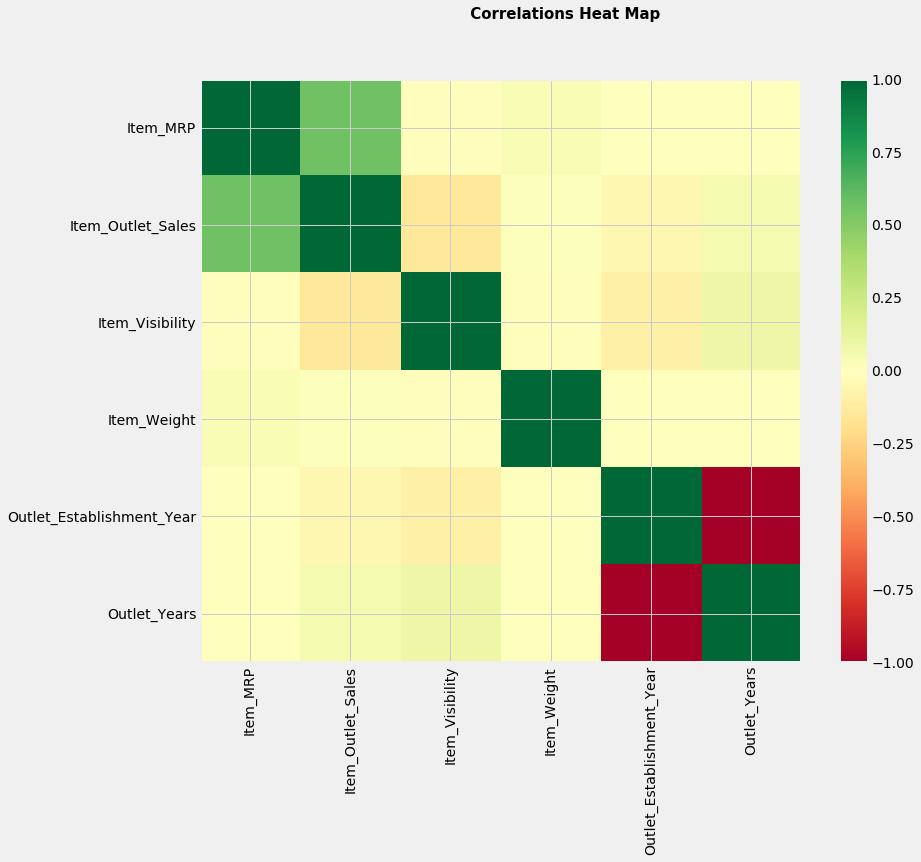

In [117]:
corr_col=data.corr()
corr_col=corr_col.fillna(0)   #Replacing Na with 0's
plt.figure(figsize=(12, 10))
plt.imshow(corr_col, cmap='RdYlGn', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_col)), corr_col.columns, rotation='vertical')
plt.yticks(range(len(corr_col)), corr_col.columns);
plt.suptitle(' Correlations Heat Map', fontsize=15, fontweight='bold')
plt.show()

Changing all the strings to numerics

In [118]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [119]:
#data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
 #                             'Item_Type_Combined','Outlet'])


In [120]:
#data.dtypes

In [121]:
data.describe()

,Item_Fat_Content,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Size,Outlet_Type,Item_Type_Combined,Outlet_Years,Outlet
count,14204.000000,14204.000000,8523.000000,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000
mean,0.895804,141.004977,2181.288914,0.069533,12.792854,1997.830681,1.112856,1.453605,1.201281,1.096381,20.169319,4.722473
std,0.894482,62.086938,1706.499616,0.048683,4.234226,8.371664,0.812755,0.683045,0.796543,0.522065,8.371664,2.837101
min,0.000000,31.290000,33.290000,0.003575,4.555000,1985.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000
25%,0.000000,94.012000,834.247400,0.033143,9.300000,1987.000000,0.000000,1.000000,1.000000,1.000000,14.000000,2.000000
50%,1.000000,142.247000,1794.331000,0.057851,12.792854,1999.000000,1.000000,2.000000,1.000000,1.000000,19.000000,5.000000
75%,2.000000,185.855600,3101.296400,0.094037,16.000000,2004.000000,2.000000,2.000000,1.000000,1.000000,31.000000,7.000000
max,2.000000,266.888400,13086.964800,0.328391,21.350000,2009.000000,2.000000,2.000000,3.000000,2.000000,33.000000,9.000000


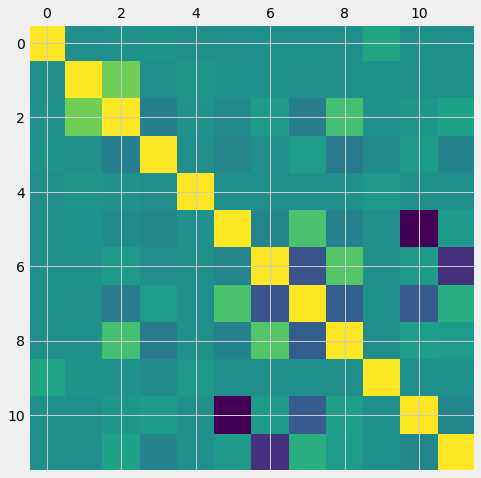

In [122]:
plt.matshow(data.corr())

In [123]:
corr_col=data.corr()
corr_col

,Item_Fat_Content,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Size,Outlet_Type,Item_Type_Combined,Outlet_Years,Outlet
Item_Fat_Content,1.000000,-0.000289,0.015249,0.018008,-0.009391,-0.000231,0.001068,0.000500,-0.000801,0.187207,0.000231,-0.001019
Item_MRP,-0.000289,1.000000,0.567574,-0.008522,0.033002,0.000141,0.000838,-0.001052,0.000136,0.030219,-0.000141,-0.000555
Item_Outlet_Sales,0.015249,0.567574,1.000000,-0.134161,0.011083,-0.049135,0.089367,-0.162753,0.401522,0.011236,0.049135,0.162325
Item_Visibility,0.018008,-0.008522,-0.134161,1.000000,-0.015181,-0.088450,-0.019299,0.095184,-0.173592,-0.054509,0.088450,-0.109317
Item_Weight,-0.009391,0.033002,0.011083,-0.015181,1.000000,0.000462,-0.002104,-0.000432,0.001699,0.062660,-0.000462,0.003274
Outlet_Establishment_Year,-0.000231,0.000141,-0.049135,-0.088450,0.000462,1.000000,-0.089328,0.425568,-0.122519,-0.002226,-1.000000,0.079047
Outlet_Location_Type,0.001068,0.000838,0.089367,-0.019299,-0.002104,-0.089328,1.000000,-0.480055,0.467251,-0.002572,0.089328,-0.716151
Outlet_Size,0.000500,-0.001052,-0.162753,0.095184,-0.000432,0.425568,-0.480055,1.000000,-0.401405,0.001583,-0.425568,0.260217
Outlet_Type,-0.000801,0.000136,0.401522,-0.173592,0.001699,-0.122519,0.467251,-0.401405,1.000000,-0.001956,0.122519,0.099899
Item_Type_Combined,0.187207,0.030219,0.011236,-0.054509,0.062660,-0.002226,-0.002572,0.001583,-0.001956,1.000000,0.002226,0.001090


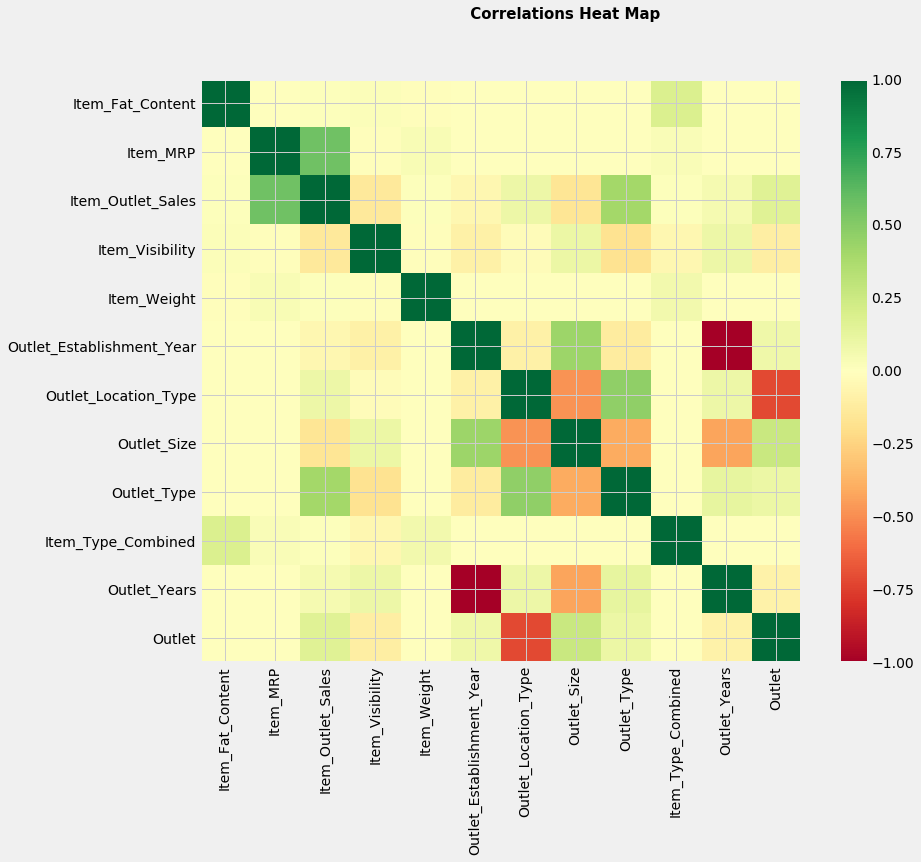

In [124]:
corr_col=data.corr()
corr_col=corr_col.fillna(0)   #Replacing Na with 0's
plt.figure(figsize=(12, 10))
plt.imshow(corr_col, cmap='RdYlGn', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_col)), corr_col.columns, rotation='vertical')
plt.yticks(range(len(corr_col)), corr_col.columns);
plt.suptitle(' Correlations Heat Map', fontsize=15, fontweight='bold')
plt.show()

We saw previously that Item_Weight had a low correlation with our target variable. If we plot both features we can see that relationship.

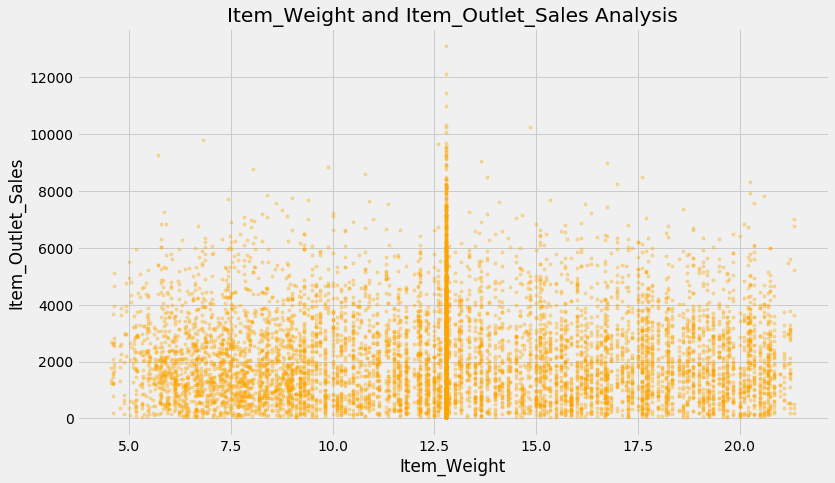

In [125]:
plt.figure(figsize=(12,7))
plt.xlabel("Item_Weight")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item_Weight and Item_Outlet_Sales Analysis")
plt.plot(data.Item_Weight, data["Item_Outlet_Sales"],'.', alpha = 0.3,color='orange')

The location of product in a store will impact sales. 

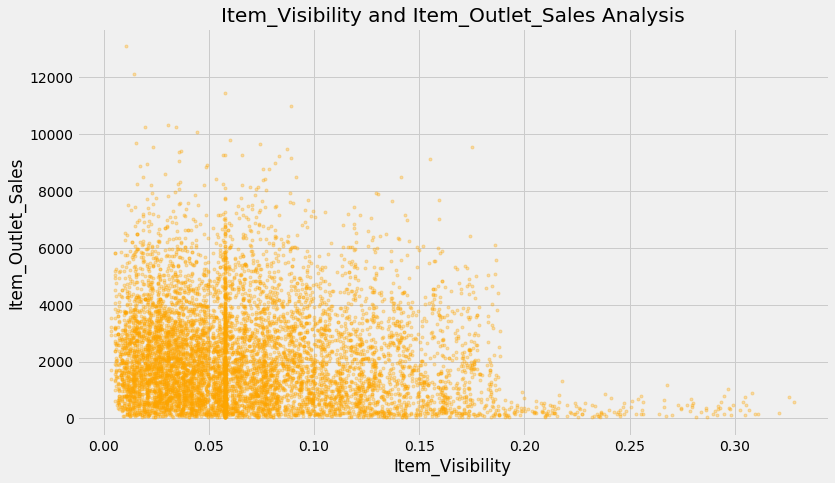

In [126]:
plt.figure(figsize=(12,7))
plt.xlabel("Item_Visibility")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item_Visibility and Item_Outlet_Sales Analysis")
plt.plot(data.Item_Visibility, data["Item_Outlet_Sales"],'.', alpha = 0.3,color='orange')

This plot chart, indicate that the more visible a product is the less higher its sales will be. This might be due to the fact that a great number of daily use products, which do not need high visibility, control the top of the sales chart.

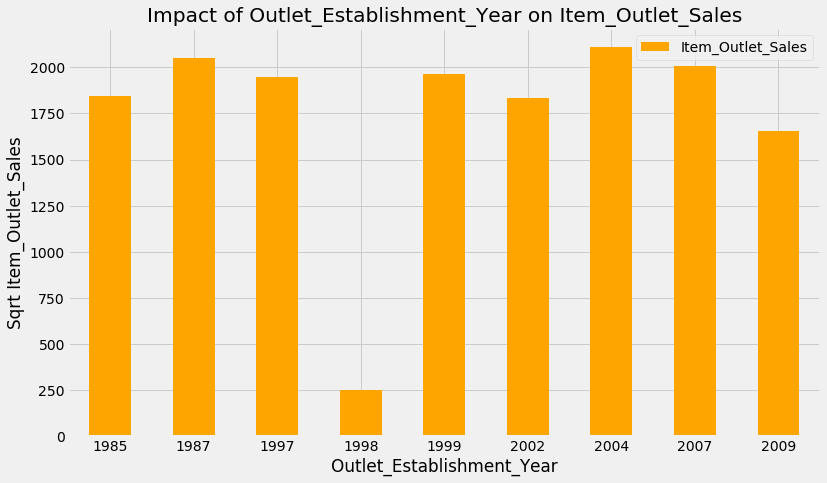

In [127]:
Outlet_Establishment_Year_pivot = \
data.pivot_table(index='Outlet_Establishment_Year', values="Item_Outlet_Sales", aggfunc=np.median)
Outlet_Establishment_Year_pivot.plot(kind='bar', color='orange',figsize=(12,7))
plt.xlabel("Outlet_Establishment_Year")
plt.ylabel("Sqrt Item_Outlet_Sales")
plt.title("Impact of Outlet_Establishment_Year on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

There seems to be no significant meaning between the year of store establishment and the sales for the items. 1998 has low values but thet might be due to the fact the few stores opened in that year.

In [128]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Combined,Outlet_Years,Outlet
0,0,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,0,1,1,train,1,19,9
1,2,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,2,1,2,train,0,9,3
2,0,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,0,1,1,train,1,19,9
3,2,FDX07,182.0950,732.3800,Fruits and Vegetables,0.057851,19.20,1998,OUT010,2,2,0,train,1,20,0
4,1,NCD19,53.8614,994.7052,Household,0.057851,8.93,1987,OUT013,2,0,1,train,2,31,1


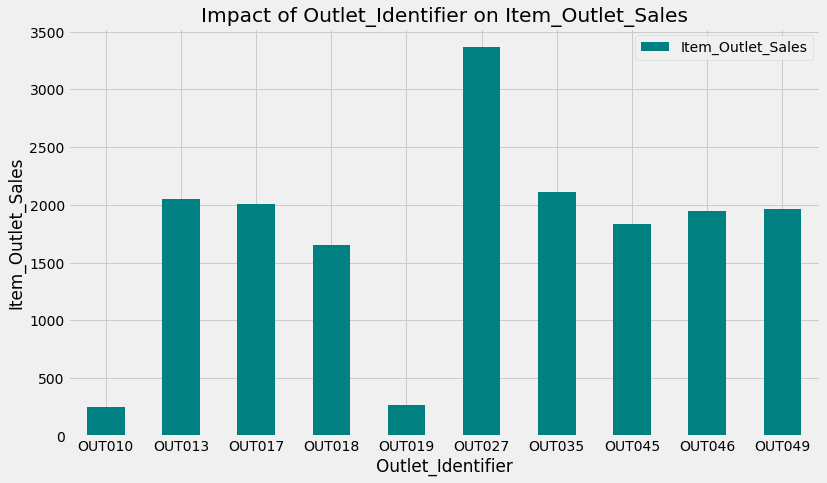

In [129]:
Outlet_Identifier_pivot = \
data.pivot_table(index='Outlet_Identifier', values="Item_Outlet_Sales", aggfunc=np.median)
Outlet_Identifier_pivot.plot(kind='bar', color='teal',figsize=(12,7))
plt.xlabel("Outlet_Identifier")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Identifier on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()


From the ten stores, two are Groceries whereas six are Supermarket Type1, one Supermarket Type2 and one Supermarket Type3. You can get this information from the pivot_tables below.


In [130]:
train.pivot_table(values='Outlet_Type', columns='Outlet_Identifier',aggfunc=lambda x:x.mode())

Outlet_Identifier,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type1,Supermarket Type2,Grocery Store,Supermarket Type3,Supermarket Type1,Supermarket Type1,Supermarket Type1,Supermarket Type1


From the above bar chart, we see that thr groceries (“OUT010”, “OUT019”) have the lowest sales results which is expected followed by the Supermarket Type 2 (“OUT018”). Curiously, most stores are of type Supermarket Type1 of size “High” and do not have the best results. The best results belong to “Out027” which is a “Medium” size Supermarket Type 3.


In [131]:
train.pivot_table(values='Outlet_Type', columns='Outlet_Size',aggfunc=lambda x:x.mode())

Outlet_Size,High,Medium,Small
Outlet_Type,Supermarket Type1,Supermarket Type3,Supermarket Type1


In [132]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Combined,Outlet_Years,Outlet
0,0,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,0,1,1,train,1,19,9
1,2,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,2,1,2,train,0,9,3
2,0,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,0,1,1,train,1,19,9
3,2,FDX07,182.0950,732.3800,Fruits and Vegetables,0.057851,19.20,1998,OUT010,2,2,0,train,1,20,0
4,1,NCD19,53.8614,994.7052,Household,0.057851,8.93,1987,OUT013,2,0,1,train,2,31,1


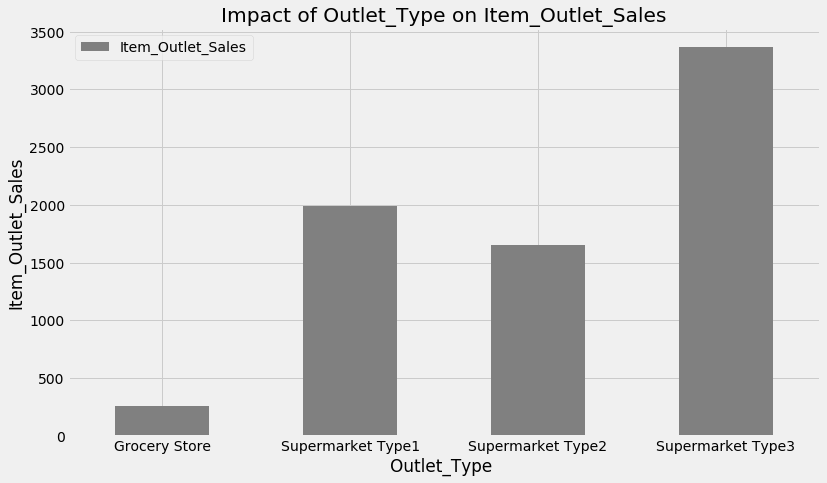

In [133]:
Outlet_Type_pivot = \
train.pivot_table(index='Outlet_Type', values="Item_Outlet_Sales", aggfunc=np.median)
Outlet_Type_pivot.plot(kind='bar', color='grey',figsize=(12,7))
plt.xlabel("Outlet_Type ")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Type on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

In [134]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Combined,Outlet_Years,Outlet
0,0,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,0,1,1,train,1,19,9
1,2,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,2,1,2,train,0,9,3
2,0,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,0,1,1,train,1,19,9
3,2,FDX07,182.0950,732.3800,Fruits and Vegetables,0.057851,19.20,1998,OUT010,2,2,0,train,1,20,0
4,1,NCD19,53.8614,994.7052,Household,0.057851,8.93,1987,OUT013,2,0,1,train,2,31,1


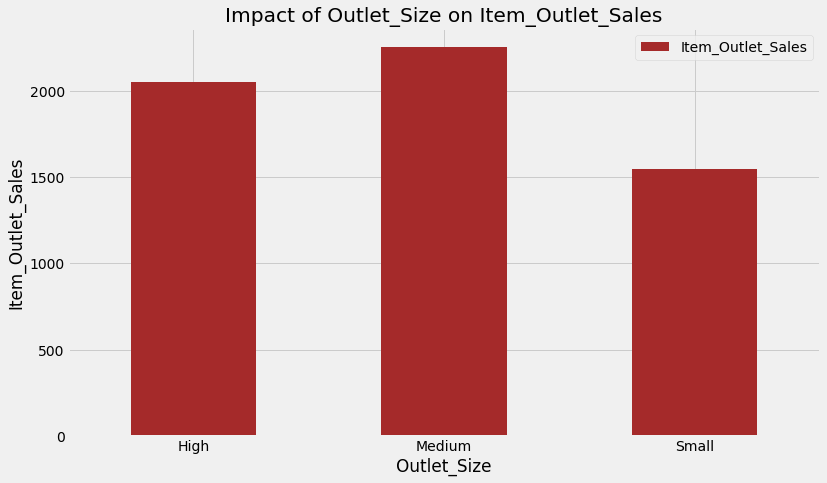

In [135]:
Outlet_Size_pivot = \
train.pivot_table(index='Outlet_Size', values="Item_Outlet_Sales", aggfunc=np.median)
Outlet_Size_pivot.plot(kind='bar', color='brown',figsize=(12,7))
plt.xlabel("Outlet_Size")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Size on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

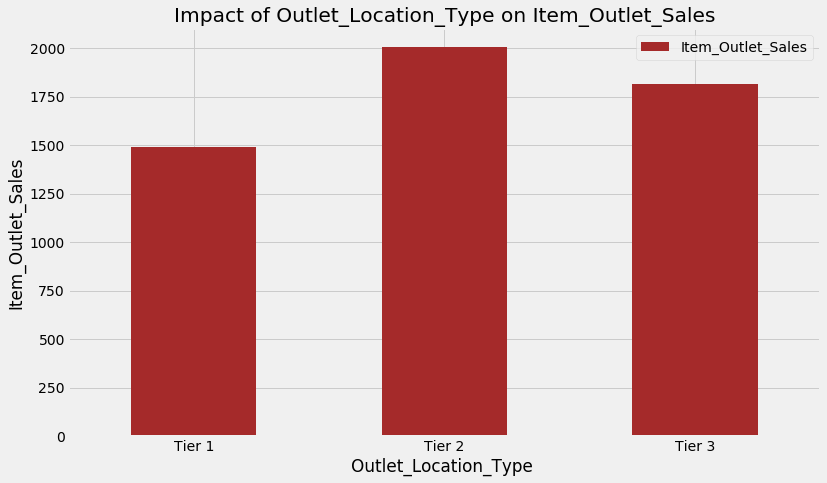

In [136]:
Outlet_Location_Type_pivot = \
train.pivot_table(index='Outlet_Location_Type', values="Item_Outlet_Sales", aggfunc=np.median)
Outlet_Location_Type_pivot.plot(kind='bar', color='brown',figsize=(12,7))
plt.xlabel("Outlet_Location_Type ")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Location_Type on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()


From our results we see that in fact it is stores from Tier 2 cities that present the highest results, followed by Tier 3 cities and with Tier 1 cities with the lowest results of the three type of locations.

The Tier2 and Tier3 cities are those that have highest representation of stores.

In [137]:
train.pivot_table(values='Outlet_Location_Type', columns='Outlet_Type',aggfunc=lambda x:x.mode())

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Location_Type,Tier 3,Tier 2,Tier 3,Tier 3


In [138]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Combined,Outlet_Years,Outlet
0,0,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,0,1,1,train,1,19,9
1,2,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,2,1,2,train,0,9,3
2,0,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,0,1,1,train,1,19,9
3,2,FDX07,182.0950,732.3800,Fruits and Vegetables,0.057851,19.20,1998,OUT010,2,2,0,train,1,20,0
4,1,NCD19,53.8614,994.7052,Household,0.057851,8.93,1987,OUT013,2,0,1,train,2,31,1


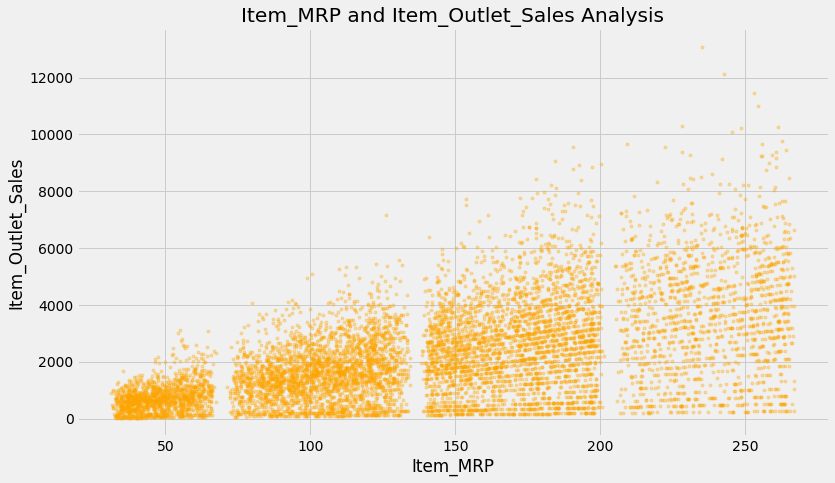

In [139]:
plt.figure(figsize=(12,7))
plt.xlabel("Item_MRP")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item_MRP and Item_Outlet_Sales Analysis")
plt.plot(data.Item_MRP, data["Item_Outlet_Sales"],'.', alpha = 0.3,color='orange')

# MODELING

## Performance Measure

ROOT MEAN SQUARE is a function which gives an idea of how much error the system makes in its predictions with higher weight for large errors.

R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression. ... 100% indicates that the model explains all the variability of the response data around its mean.

In [140]:
data.Item_MRP.describe()


count    14204.000000
mean       141.004977
std         62.086938
min         31.290000
25%         94.012000
50%        142.247000
75%        185.855600
max        266.888400
Name: Item_MRP, dtype: float64

In [141]:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])


In [142]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

FUNCTION

In [143]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import cross_validation, metrics
def model(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print "\nModel Report"
    print "RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions))
    print " R2_Score = ",metrics.r2_score(dtrain[target].values, dtrain_predictions)
    print "CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

LINEAR REGRESSION


Model Report
RMSE : 1127
 R2_Score =  0.5634817149505081
CV Score : Mean - 1129 | Std - 43.72 | Min - 1075 | Max - 1212


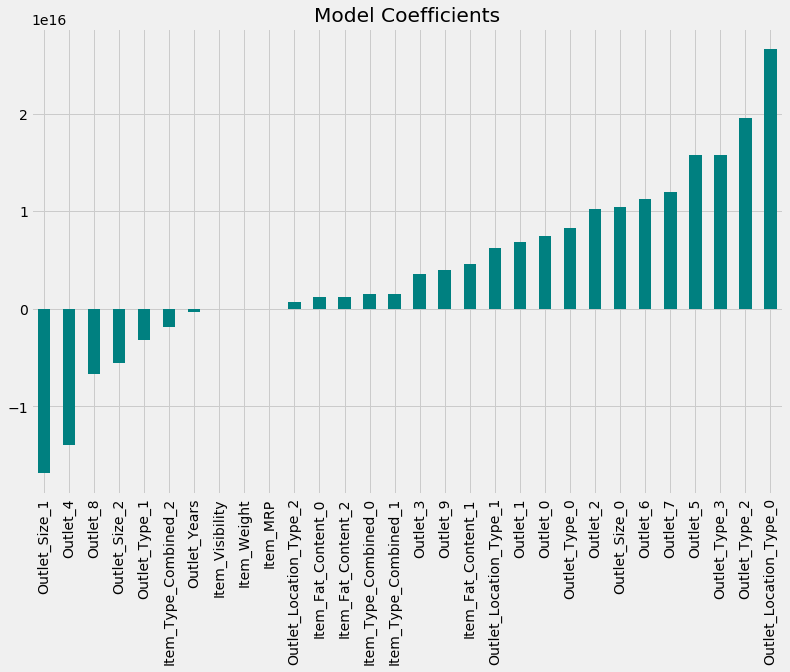

In [144]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
model(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
#plt.scatter(alg1, predictors, color='navy', s=30, marker='o')
coef1.plot(kind='bar', title='Model Coefficients',color='teal')


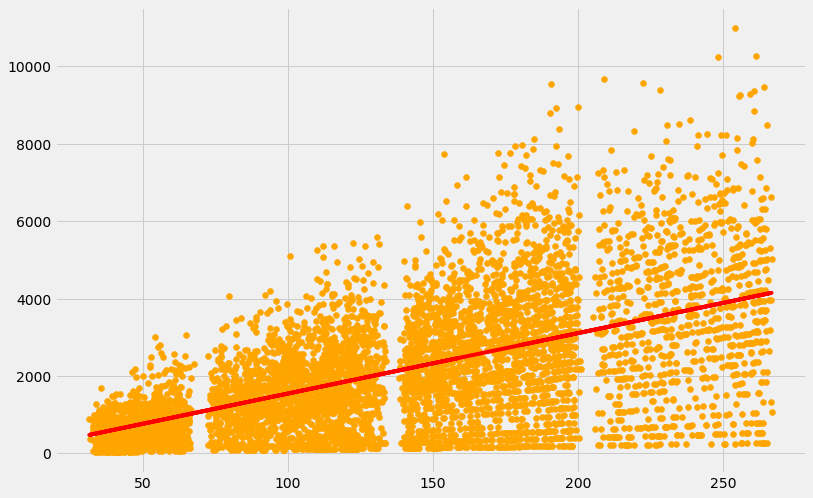

32.27

In [145]:
from sklearn.linear_model import LinearRegression
model_LR = LinearRegression()
X = train.loc[:,['Item_MRP']]
y = train.loc[:,['Item_Outlet_Sales']]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)
model_LR.fit(X_train,y_train)
y_predict=model_LR.predict(X_test)
plt.scatter(X_train,y_train,color='orange')
plt.plot(X_test,y_predict,color='red')
plt.show()
model_LR_accuracy = round(model_LR.score(X_train,y_train) * 100,2)
model_LR_accuracy

RIDGE REGRESSION

In [146]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
model(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
#coef2.plot(kind='bar', title='Model Coefficients')


Model Report
RMSE : 1128
 R2_Score =  0.5626561006803446
CV Score : Mean - 1130 | Std - 44.7 | Min - 1076 | Max - 1217


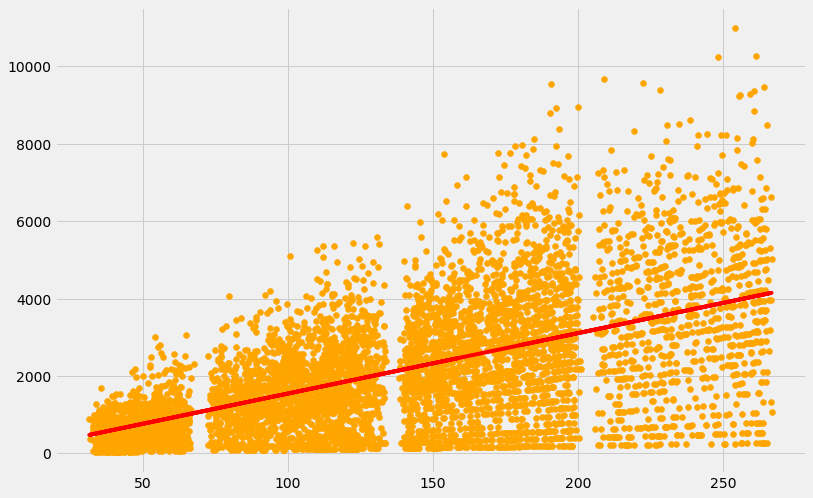

32.27

In [147]:
from sklearn.linear_model import Ridge
model_RR = Ridge()
X = train.loc[:,['Item_MRP']]
y = train.loc[:,['Item_Outlet_Sales']]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)
model_RR.fit(X_train,y_train)
y_predict=model_RR.predict(X_test)
plt.scatter(X_train,y_train,color='orange')
plt.plot(X_test,y_predict,color='red')
plt.show()
model_RR_accuracy = round(model_RR.score(X_train,y_train) * 100,2)
model_RR_accuracy

RANDOM FOREST REGRESSION


Model Report
RMSE : 1073
 R2_Score =  0.6044377086925407
CV Score : Mean - 1084 | Std - 43.7 | Min - 1021 | Max - 1161


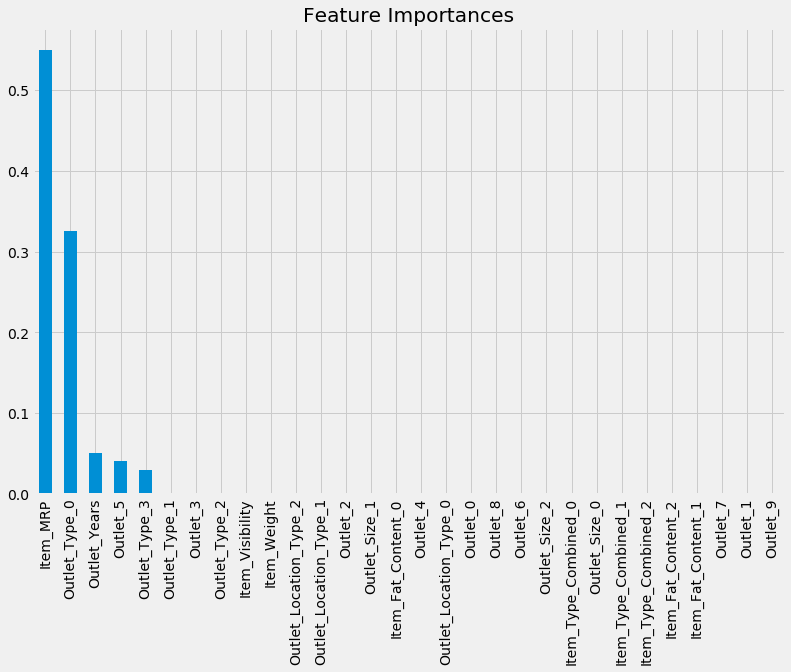

In [148]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
model(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')



Model Report
RMSE : 1068
 R2_Score =  0.6081487118055089
CV Score : Mean - 1082 | Std - 43.54 | Min - 1019 | Max - 1159


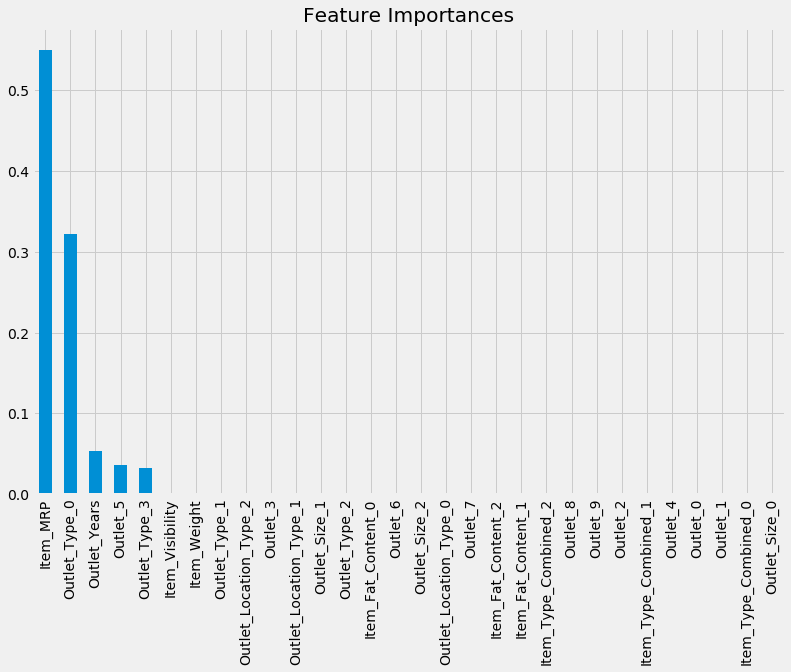

In [149]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
model(alg6, train, test, predictors, target, IDcol, 'alg6.csv')
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances')

In [150]:
rf = RandomForestRegressor(n_estimators=5,max_depth=6, min_samples_leaf=100,n_jobs=4)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
rf_accuracy = round(rf.score(X_train,y_train)*100,2)
rf_accuracy



33.21

After Obseriving all the predictions i found that i got better accuracy and R-Squared values for Random Forest Regression of 33.2 percent and 60.8 compared to linear and ridge regression where i got 32.27 percent and 56.2 percent 